# Plan

* grab some top 100 posts from various popular nsfw subreddits
* identify the posters
* check if the redditors have "onlyfans" in their bio

In [1]:
import praw
from secrets import * # reddit api credentials put into a different file
import pandas as pd

In [2]:
#user your own secrets here
r = praw.Reddit(client_id=CLIENT_ID, 
                client_secret=CLIENT_SECRET, 
                user_agent=USER_AGENT)

In [3]:
def get_post_df(praw_post_list):
    """
    takes a praw submission generator and returns a pandas DataFrame 
    >>> praw_post_list = reddit.subreddit('all').top('month', limit=100)
    """
    # make dataframe
    df = pd.DataFrame([vars(post) for post in praw_post_list])
    df["author_name"] = df.author.apply(lambda a: a.name if a else '[deleted]')
    df["subreddit_name"] = df.subreddit.apply(lambda a: a.display_name if a else 'deletedsub')
    return df

In [4]:
def filter_unique_posters(df):
    return df[["subreddit","subreddit_name","author_name","author"]].drop_duplicates(subset=["author_name"])

def add_author_info(df):
    "remember: this makes a http call for each row in the df so it's slow"
    def get_desc(redditor):
        if not redditor:
            return "[deleted]"
        if getattr(redditor, "is_suspended", None):
            return "[suspended]"
#         print(redditor.name) 
        if not redditor.subreddit:
            return "[no description]"
        return redditor.subreddit["public_description"]
    df["public_description"] = df.author.apply(get_desc)
    return df

def add_has_onlyfans(df):
    df["has_onlyfans"] = df.public_description.str.contains("onlyfans|OnlyFans|OF", case=True)
    return df
    

In [5]:
def prep_uniq_redditors_df(df):
    return (df.pipe(filter_unique_posters)
            .pipe(add_author_info)
            .pipe(add_has_onlyfans)
           )

In [6]:
nsfw_oc_subs = [
    'gonewild',
    'RealGirls',
    'LegalTeens',
    'cumsluts',
    'BustyPetite',
    'PetiteGoneWild',
    'holdthemoan',
    'collegesluts',
    'AsiansGoneWild',
    'GirlsFinishingTheJob',
    'adorableporn',
    'TittyDrop',
    'BiggerThanYouThought',
    'ass',
    'Amateur',
    'milf',
    'pawg',
    'pussy',
    'BreedingMaterial',
    'gonewild30plus',
    'GWCouples',
    '18_19',
    'curvy',
    'dirtysmall',
    'Boobies'
]

The code below was used to gather all the data from the subs and posters. This takes quite a long time.

I've commented it out because I'm providing the dataset that I pickled in the repo.

Please feel free to  uncomment and rerun the below if you want new data

In [7]:
# %%time
# dfs = [prep_uniq_redditors_df(get_post_df(r.subreddit(sub).new(limit=1000)))
#        for sub in nsfw_oc_subs]

# this took 35min

In [8]:
## code below pickles the data on to disk
# big_df = pd.concat(dfs)
# big_df.to_pickle("big_df.pkl")

In [9]:
big_df = pd.read_pickle("big_df.pkl")

## code below formats the data and plots this sucker

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [19]:
big_df = big_df.pipe(add_has_onlyfans) # This corrects a mistake from when I pulled the data

In [21]:
grouped = big_df.groupby(["subreddit_name", "has_onlyfans"]).size().unstack()

In [22]:
grouped.columns = ["no_of", "of"]
grouped["total"] = grouped.sum(axis=1)
grouped = grouped.reset_index().sort_values("total", ascending=False)
grouped

,subreddit_name,no_of,of,total
19,gonewild,742,5,747
5,BreedingMaterial,318,425,743
24,pussy,402,276,678
13,adorableporn,237,420,657
15,collegesluts,283,356,639
17,curvy,301,334,635
12,TittyDrop,312,303,615
2,AsiansGoneWild,361,228,589
14,ass,296,274,570
16,cumsluts,401,159,560


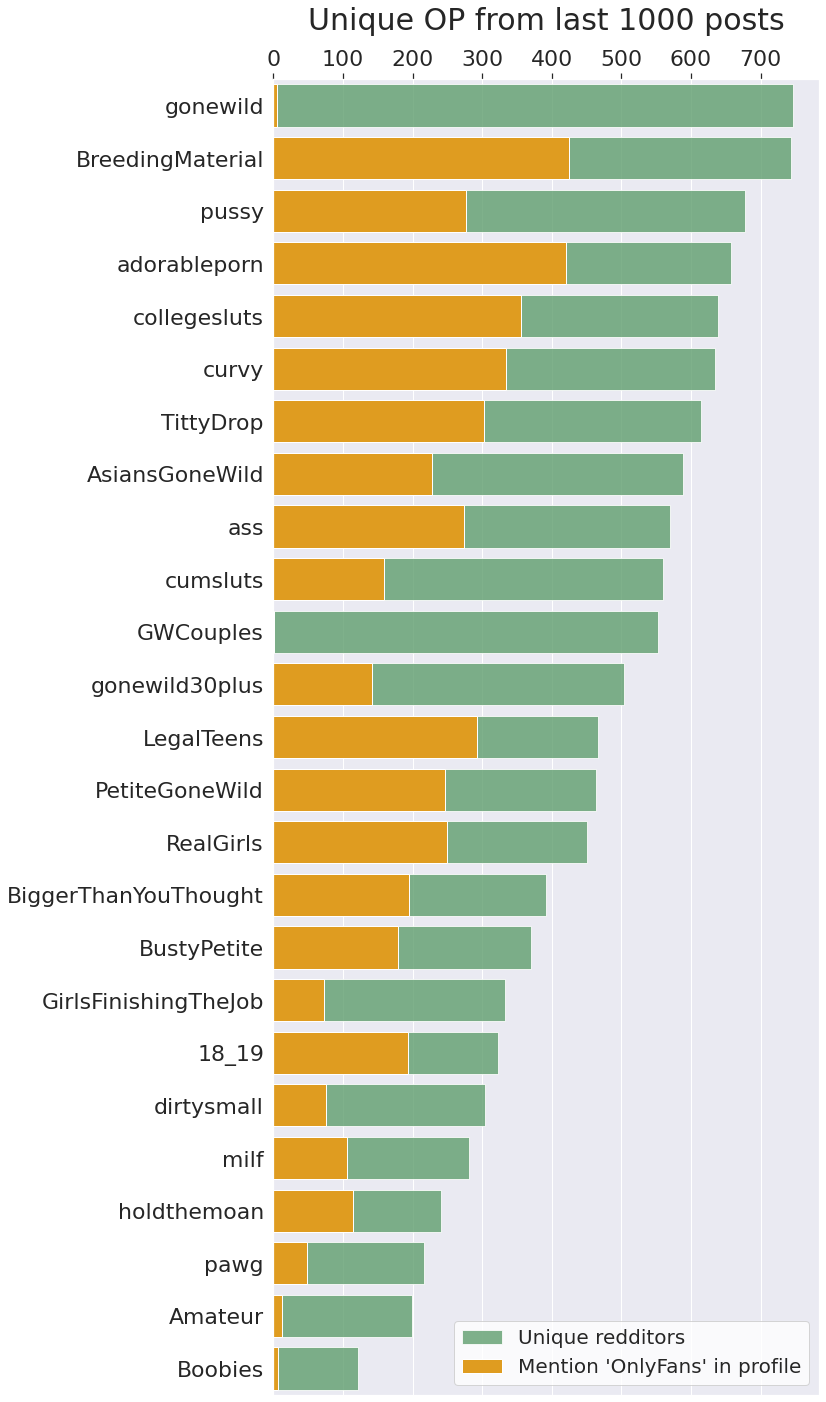

In [23]:
# plot
sns.set(font_scale = 2)
f, ax = plt.subplots(figsize=(12,20))

sns.set_color_codes("deep")
sns.barplot(x="total", y="subreddit_name", data=grouped,
           label="Unique redditors", color="g", alpha=.8)

#plot posters with onlyfans
sns.barplot(x="of", y="subreddit_name", data=grouped,
           label="Mention 'OnlyFans' in profile", color="orange")

ax.legend(ncol=1, loc="lower right", frameon=True, facecolor="white", fontsize=20)

ax.set(ylabel="", xlabel="")
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
plt.title("Unique OP from last 1000 posts", pad=20, size=30, **hfont)
plt.tight_layout()
plt.savefig('onlyfanification.png')

In [15]:
big_df.query("subreddit_name == 'gonewild' and has_onlyfans").public_description.values

array(['PLAYER STATS: 23 y/o, 5’2, 32G, no kik or snapchat or onlyfans, don’t do custom requests. It’s free titties guys. Just let them be free community titties',
       '30s male dom owner of 20s female brat. Shared account',
       'Hi! I’m Connie, I’m a French college girl and I love anime and manga 💕 also I like making slutty pictures and naughty videos of myself for the net 🤤 no IRL interactions💋 I’m a 2D anime girl',
       ' Outdoor enthusiast & lover of nakedness.',
       'Hey 💕 I’m Riley, a med student from currently living in CA. I love politics, Christmas movies, and lots and lots of sex',
       "I'm 22 I love in the caribbean all pics and vid are of me my old account was banned wrongfully",
       '“I snap my claws seductively in your general direction, foaming. I hope to scream our everlasting love for each other as we boil to our delicious deaths, to be masticated with copious globs of butter”',
       "Hey I'm Ethan, 25 years old, currently in the process of making my

In [16]:
big_df.query('subreddit_name == "Boobies"').author_name.value_counts()

ThunderRAss             1
promotionbbw            1
throwawayacct459        1
alexandrasaunt          1
shawnsmith747           1
                       ..
uncutbandit             1
regularsatnightthing    1
showtimekick            1
MadWit-itDug            1
DrFunkenF00tz           1
Name: author_name, Length: 121, dtype: int64

In [17]:
b = get_post_df(r.subreddit('Boobies').new(limit=1000))

In [18]:
b.author_name.value_counts()

altbubblr            144
thecrisisonreddit    115
deputyduffy           85
The-Shinning          62
PopeJudas             51
                    ... 
OtherWalter            1
BeMyMellon             1
Insert_C0ins           1
Risky_Behavior         1
DrFunkenF00tz          1
Name: author_name, Length: 120, dtype: int64